In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [4]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.4/"  # path to all opsim databases

dbname = "baseline_v1.4_10yrs.db"  # name of opsim database
opsdb = db.OpsimDatabase(dbpath+dbname)

# output directory
outDir = 'outDir'
resultsDb = db.ResultsDb(outDir=outDir)


In [ ]:
#
# connect to opsim database
#opsdb_baseline = db.OpsimDatabase('opsdb/baseline2018a.db')
#opsdb_pontus = db.OpsimDatabase('opsdb/pontus_2573.db')
#opsdb_baseline10yrs = db.OpsimDatabase('opsdb/baseline_2snap_v1.3_10yrs.db')
#opsdb_baseline10yrs_nomix = db.OpsimDatabase('opsdb/baseline_nomix_v1.3_10yrs.db')


filterTimeGapsMetric

In [40]:
class filterTimeGapsMetric(metrics.BaseMetric):
    """
    returns all time gaps between two filters
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                 filename='dT.pkl', fltpair=['y','i'],
                 dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.dataout = dataout
        
        if os.path.isfile(filename):
            # rm old file
            os.system("rm {}".format(filename))
        
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
        
    def dT(self, dataSlice, f0='i', f1='r'):
        ''' return an array that contains all time gaps between two filters'''
        idx0 = dataSlice['filter'] == f0
        idx1 = dataSlice['filter'] == f1
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) )

        return diffmat.flatten(), timeCol0, timeCol1

    
    def load_from_pkl(self, filename="test_pkl.pkl"):
        '''load dataframe from pickle'''
        if os.path.isfile(filename):
            df = pd.read_pickle(filename)
        else:
            df = pd.DataFrame()
            df.to_pickle(filename)
        return df
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        df = self.load_from_pkl(filename)

        df = df.append(pd.DataFrame(dic), ignore_index=True)

        df.to_pickle(filename)
    
    def run(self, dataSlice, slicePoint=None):
        # sort dataSlice
        flt = ['u', 'g', 'r', 'i', 'z', 'y']
        fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        dataSlice.sort(order='observationStartMJD')

        dT, t_f0, t_f1 = self.dT(dataSlice, f0=self.fltpair[0], f1=self.fltpair[1])
        print( self.fltpair )
        
        #print(type(dataSlice['fieldRA']), dataSlice['fieldDec'])
        #dT_list = []
        #for i in range(len(dataSlice['fieldRA'])):
        #   dT_list.append(dT)
        
        # dic = {'ra':np.mean(dataSlice['fieldRA']), 'dec':np.mean(dataSlice['fieldDec']), 'dT': [dT]}
        dic = {'ra':np.mean(dataSlice['fieldRA']), 
               'dec':np.mean(dataSlice['fieldDec']), 
               'dT': [dT], 
               'f0': self.fltpair[0], 
               'f1':self.fltpair[1],
               't_f0': [t_f0.flatten()],
               't_f1': [t_f0.flatten()]
              }
        
        # print(dic)
        # save to file
        self.save_to_file(dic, self.filename)
        
        # return dT
        if self.dataout:
            result = dT
            return result
        else:
            f0 = self.fltpair[0]
            f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result)


In [7]:
np.ones((5,1)).flatten()

array([1., 1., 1., 1., 1.])

**run for one filter pair**

In [16]:
filename = 'data/tGaps_ri.pkl'
# remove old file
if os.path.isfile(filename):
    os.system("rm {}".format(filename))


In [30]:
%%time
# run the metric, check same filename in folder
metric = filterTimeGapsMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                          filename=filename, fltpair=['r','i'], dataout=False)

slicer = slicers.HealpixSlicer(nside=8)

sqlconstraint = 'night<200'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night<200 for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'fiveSigmaDepth', 'filter']
Found 142868 visits
Running:  ['metricSky']
(0, 1) (2, 1)
(2, 1) (2, 1)
(4, 1) (5, 1)
(7, 1) (7, 1)
(8, 1) (8, 1)
(4, 1) (8, 1)
(7, 1) (11, 1)
(8, 1) (8, 1)
(3, 1) (6, 1)
(0, 1) (1, 1)
(3, 1) (3, 1)
(7, 1) (5, 1)
(7, 1) (6, 1)
(4, 1) (4, 1)
(6, 1) (7, 1)
(8, 1) (10, 1)
(4, 1) (6, 1)
(6, 1) (11, 1)
(8, 1) (9, 1)
(9, 1) (8, 1)
(3, 1) (3, 1)
(0, 1) (2, 1)
(1, 1) (2, 1)
(7, 1) (5, 1)
(3, 1) (6, 1)
(9, 1) (8, 1)
(7, 1) (6, 1)
(7, 1) (7, 1)
(10, 1) (11, 1)
(6, 1) (12, 1)
(5, 1) (9, 1)
(7, 1) (8, 1)
(6, 1) (8, 1)
(9, 1) (10, 1)
(9, 1) (10, 1)
(1, 1) (0, 1)
(0, 1) (0, 1)
(0, 1) (1, 1)
(4, 1) (4, 1)
(8, 1) (5, 1)
(7, 1) (6, 1)
(6, 1) (8, 1)
(9, 1) (7, 1)
(6, 1) (6, 1)
(6, 1) (7, 1)
(6, 1) (6, 1)
(11, 1) (11, 1)
(8, 1) (10, 1)
(8, 1) (9, 1)
(6, 1) (9, 1)
(8, 1) (11, 1)
(7, 1) (

In [31]:
pd.read_pickle(filename).head()

,ra,dec,dT,f0,f1,t_f0,t_f1
0,89.730836,34.098255,[],r,i,[],[]
1,51.015667,29.859673,"[13.923705774614064, 34.983185759032494, 14.93...",r,i,"[59898.143650639984, 59899.15344510854]","[59898.143650639984, 59899.15344510854]"
2,61.403176,30.323810,"[0.01589049735775916, 0.036327784320747014, 2....",r,i,"[59897.16306365619, 59899.166609054075, 59903....","[59897.16306365619, 59899.166609054075, 59903...."
3,72.913000,30.328853,"[3.0249263951845933, 0.016278447983495425, 0.0...",r,i,"[59902.22545081345, 59907.187749368546, 59908....","[59902.22545081345, 59907.187749368546, 59908...."
4,84.362705,30.066214,"[3.9423311993814423, 3.8777570894089877, 0.015...",r,i,"[59908.18740355339, 59909.25878996884, 59911.2...","[59908.18740355339, 59909.25878996884, 59911.2..."


**run for all filter pairs**

In [41]:
# create a metric dict and run for all filter pairs

slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<400'

# create an dict to run metric for all pairs
metricSkyDict = {}
flt = ['u', 'g', 'r', 'i', 'z', 'y']
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'data/tGaps_{}{}_{}.pkl'.format(f0, f1, dbname)
        fltpair = [f0, f1]
        metric = filterTimeGapsMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                          filename=filename, fltpair=fltpair, dataout=False)
        
        metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)
        metricSkyname = 'metricSky_{}{}'.format(f0, f1)
        metricSkyDict[metricSkyname] = metricSky


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [ ]:
%%time 
group = metricBundles.MetricBundleGroup(metricSkyDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint night<400 for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'fiveSigmaDepth', 'filter']
Found 244969 visits
Running:  ['metricSky_uu', 'metricSky_ug', 'metricSky_ur', 'metricSky_ui', 'metricSky_uz', 'metricSky_uy', 'metricSky_gg', 'metricSky_gr', 'metricSky_gi', 'metricSky_gz', 'metricSky_gy', 'metricSky_rr', 'metricSky_ri', 'metricSky_rz', 'metricSky_ry', 'metricSky_ii', 'metricSky_iz', 'metricSky_iy', 'metricSky_zz', 'metricSky_zy', 'metricSky_yy']
['u', 'u']
['u', 'g']
['u', 'r']
['u', 'i']
['u', 'z']
['u', 'y']
['g', 'g']
['g', 'r']
['g', 'i']
['g', 'z']
['g', 'y']
['r', 'r']
['r', 'i']
['r', 'z']
['r', 'y']
['i', 'i']
['i', 'z']
['i', 'y']
['z', 'z']
['z', 'y']
['y', 'y']
['u', 'u']
['u', 'g']
['u', 'r']
['u', 'i']
['u', 'z']
['u', 'y']
['g', 'g']
['g', 'r']
['g', 'i']
['g', 'z']
['g', 'y']
['r', 'r']
['r', 'i']
['r', 'z']
['r', 'y']
['i', 'i']
['i', 'z']
['i', 'y']
['z', 'z']
['z', 'y']
['y', 'y']
['u', 'u']
['u', 'g']
['

**plot histgram**

In [ ]:
def cal_dT(df):
    "calculate time gaps from vist timeCol of two filters"
    f0 = df.f0
    f1 = df.f1
    
    
    

In [43]:
def get_dT(df):
    '''return dT for same filter '''
    dT = np.array([])
    for dt in df.dT:
        size = len(dt)
        if size>2:
            s = np.sqrt(size)
            dt = dt.reshape( int(s), int(s) )
            # get triangle part 
            dt_tri = np.tril(dt, -1)
            dt_tri = dt_tri[dt_tri!=0]
            dT = np.concatenate([dT, dt_tri])
    return dT


In [44]:
# load the data
flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
df_dict = {}
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'data/tGaps_{}{}_{}.pkl'.format(f0, f1, dbname)
        df = pd.read_pickle(filename)
        df_dict[filename] = df


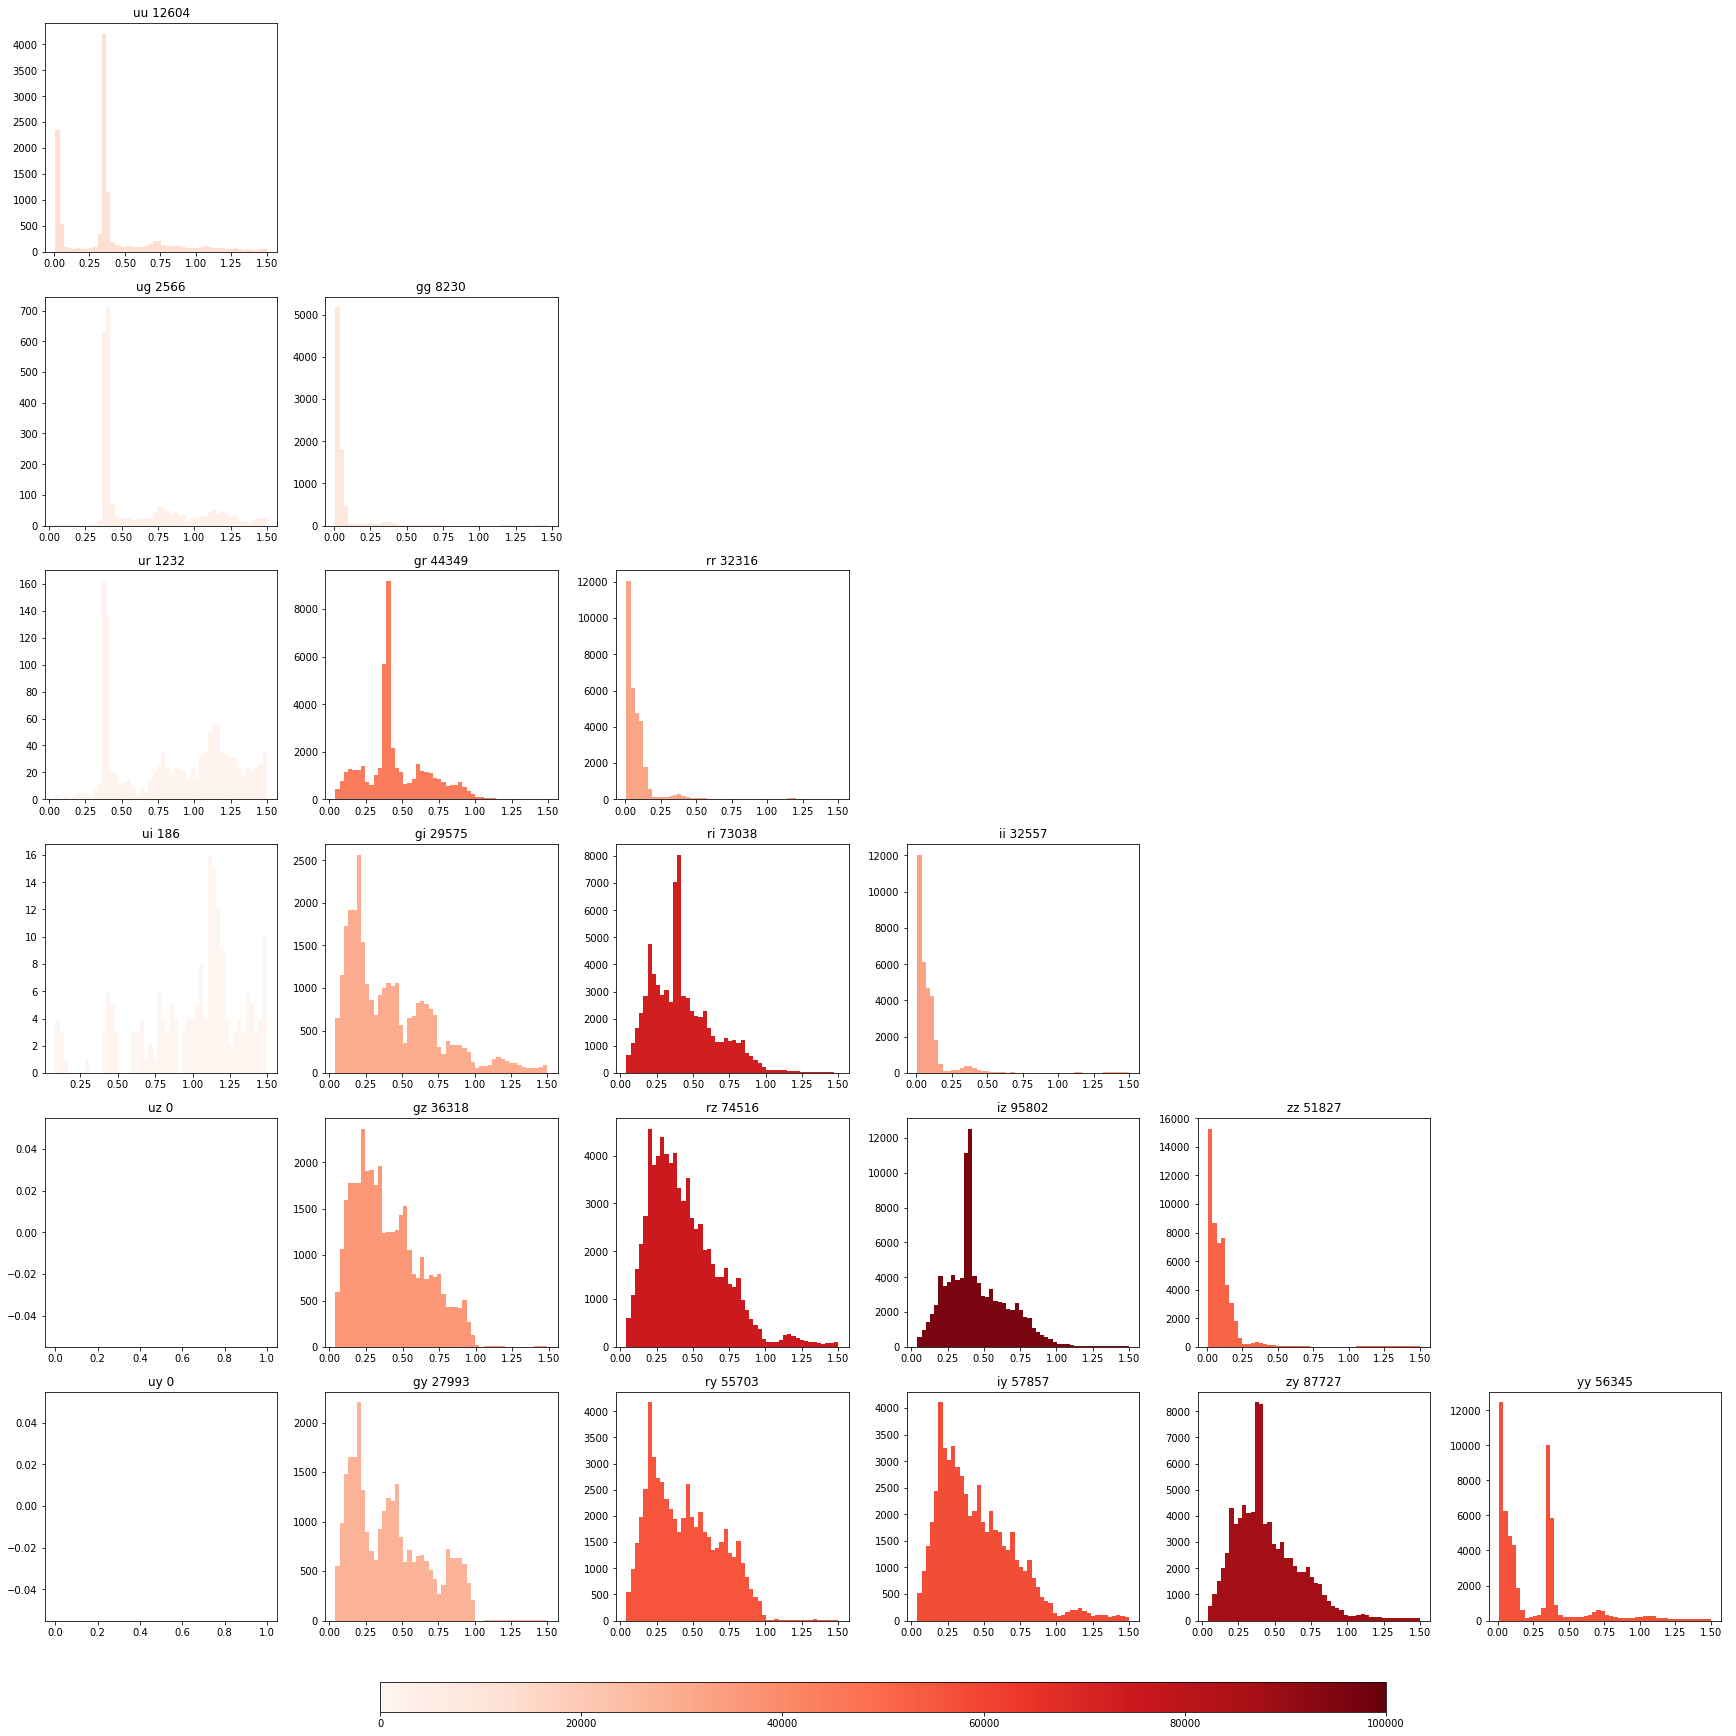

In [45]:
fig, axs = plt.subplots(6, 6, figsize=(24, 24), constrained_layout=True); # 6 axes on a 2x3 grid

opsdb = 'bsline10yrs'
flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
tlim = 1.5 # in hours
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'data/tGaps_{}{}_{}.pkl'.format(f0, f1, dbname)
        #df = pd.read_pickle(filename)
        df = df_dict[filename]

        #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
        if f0==f1:
            
            # concatenate dT
            
            dT = get_dT(df) * 24
            dT_tlim = dT[dT<tlim] 
            Ntotal = len(dT_tlim)
            
            norm = matplotlib.colors.Normalize(vmin=0, vmax=100000)
            cmap = matplotlib.cm.Reds
            m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
            
            values, bins, _ = axs[fdict[f0], fdict[f1]].hist(dT_tlim, bins=50, color=m.to_rgba(Ntotal) );
            
            axs[fdict[f1], fdict[f0]].set_title(f0+f1+ ' ' + str(Ntotal) )
            
            #axs[fdict[f0], fdict[f1]].set_xlabel('dT')

        else:
            
            dT = np.concatenate(df.dT)
            dT = dT[dT!=0] * 24   # convert to hour
            dT_tlim = dT[dT<tlim]
            
            axs[fdict[f0], fdict[f1]].axis('off')
            """
            axs[fdict[f1], fdict[f0]].hist(dT[dT<tlim/24]*24,bins=50);        
            # axs[fdict[f1], fdict[f0]].set_xlabel(f0+f1)
            axs[fdict[f1], fdict[f0]].set_title(f0+f1)
            """
            Ntotal = len(dT_tlim)
            norm = matplotlib.colors.Normalize(vmin=0, vmax=100000)
            cmap = matplotlib.cm.Reds
            m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
            
            values, bins, _ = axs[fdict[f1], fdict[f0]].hist(dT_tlim, bins=50, color=m.to_rgba(Ntotal) );
            
            axs[fdict[f1], fdict[f0]].set_title(f0+f1+' '+ str(Ntotal) )

m.set_array(np.linspace(0, 100000) )            
fig.colorbar(mappable=m, ax=axs[:,:], shrink=0.6, location='bottom')


In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(24, 24), constrained_layout=True); # 6 axes on a 2x3 grid

flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
tlim = 1.5 # in hours
tmin = 1/60 # minimum time gap in hours 
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'data/dT_{}{}_{}.pkl'.format(f0, f1, dbname)
        #df = pd.read_pickle(filename)
        df = df_dict[filename]

        #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
        if f0==f1:
            
            # concatenate dT
            
            dT = get_dT(df) * 24
            dT_tlim = dT[ (dT<tlim) & (dT>tmin)] 
            Ntotal = len(dT_tlim)
            
            norm = matplotlib.colors.Normalize(vmin=0, vmax=100000)
            cmap = matplotlib.cm.Reds
            m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
            
            values, bins, _ = axs[fdict[f0], fdict[f1]].hist(dT_tlim, bins=50, color=m.to_rgba(Ntotal) );
            
            axs[fdict[f1], fdict[f0]].set_title(f0+f1+ ' ' + str(Ntotal) )
            
            #axs[fdict[f0], fdict[f1]].set_xlabel('dT')

        else:
            
            dT = np.concatenate(df.dT)
            dT = dT[dT!=0] * 24   # convert to hour
            dT_tlim = dT[(dT<tlim) & (dT>tmin)]
            
            axs[fdict[f0], fdict[f1]].axis('off')
            """
            axs[fdict[f1], fdict[f0]].hist(dT[dT<tlim/24]*24,bins=50);        
            # axs[fdict[f1], fdict[f0]].set_xlabel(f0+f1)
            axs[fdict[f1], fdict[f0]].set_title(f0+f1)
            """
            Ntotal = len(dT_tlim)
            norm = matplotlib.colors.Normalize(vmin=0, vmax=100000)
            cmap = matplotlib.cm.Reds
            m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
            
            values, bins, _ = axs[fdict[f1], fdict[f0]].hist(dT_tlim, bins=50, color=m.to_rgba(Ntotal) );
            
            axs[fdict[f1], fdict[f0]].set_title(f0+f1+' '+ str(Ntotal) )

m.set_array(np.linspace(0, 100000) )            
fig.colorbar(mappable=m, ax=axs[:,:], shrink=0.6, location='bottom')


 -------------------

In [9]:
df = pd.DataFrame([1,2,3,4,5, 6])

In [10]:
filename = "data/test.pkl"
df.to_pickle(filename)

In [15]:
filename = "data/test.pkl"
if os.path.isfile(filename):
    os.system("rm {}".format(filename))


In [16]:
import matplotlib.cm as cm


In [37]:
cm.Reds()

(1.0, 0.9607843137254902, 0.9411764705882353, 1.0)

In [18]:
cm.hot_r(20)

(1.0, 1.0, 0.691176161764397, 1.0)

In [38]:

norm = matplotlib.colors.Normalize(vmin=-20, vmax=20)
cmap = cm.Reds

m = cm.ScalarMappable(norm=norm, cmap=cmap)

x = 20
print(m.to_rgba(x))


(0.403921568627451, 0.0, 0.05098039215686274, 1.0)


In [ ]:
f0, f1 = 'r', 'i'
filename = 'data/dT_{}{}.pkl'.format(f0, f1)
df = pd.read_pickle(filename)
#df = df_dict[filename]
dT = np.concatenate(df.dT)
dT = dT[dT!=0]
tlim = 1.5
values, bins, _ = plt.hist(dT[dT < tlim/24]*24, bins=50, density=False, 
                           color=m.to_rgba(-20));
area = sum(np.diff(bins)*values)

plt.xlabel('dT (hour)')
plt.ylabel('Nvisits')
plt.title(f0+f1)

Text(0.5, 1.0, 'ri')

In [31]:
area

2124.6913772556

In [ ]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[-1, 0])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[-1, -2])
f3_ax5.set_title('gs[-1, -2]')
